# Strategy Optimization and advanced Performance Measurement

## Getting started

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [ ]:
df = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
df

In [ ]:
# Version 1.0
class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        multiple = round(self.results.cstrategy[-1], 6)
        print("Strategy-Multiple: {}".format(multiple))
    
    def prepare_data(self, window):
        
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

In [ ]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [ ]:
tester = ConBacktester(filepath= "intraday.csv", symbol = symbol, start = start, end = end, tc = tc)
tester

In [ ]:
tester.test_strategy(window = 3)

In [ ]:
tester.results.cstrategy[-1]

## Finding the optimal  value for the "window" Parameter 

__Plan: Backtest all Strategies from window == 1 to window == 1000__

In [ ]:
window_range = (1, 1001, 1) # tuple of the form (start, stop, step size)
window_range 

In [ ]:
windows = range(*window_range) # unpack the tuple and create a range object
windows

In [ ]:
tester

In [ ]:
performance = []
for window in windows:
    tester.prepare_data(window) # prepate data -> window
    tester.run_backtest() # backtest strategy
    performance.append(np.exp(tester.results.strategy.sum())) # calculate and store the mulitple

In [ ]:
performance

In [ ]:
results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
results_overview

In [ ]:
results_overview["Performance"] = performance
results_overview

In [ ]:
results_overview.sort_values(by = "Performance", ascending = False)

In [ ]:
best = results_overview.nlargest(1, "Performance")
best

In [ ]:
window = best.Windows.iloc[0]
perf = best.Performance.iloc[0]
print("Windows: {} | Multiple: {}".format(window, round(perf, 6)))

## Relationship between the "window" Parameter and Performance

In [ ]:
results_overview.sort_values(by = "Performance", ascending = False)

Window == 51 is the best performing strategy (in the past). __How reliable is that (for the future)__?

Is this __just by chance (random noise)__...<br>
...or is there a systematic (functional) __relationship between the window parameter and the performance__ (desirable)?

In [ ]:
results_overview.set_index("Windows", inplace = True)
results_overview

In [ ]:
results_overview.plot(figsize = (12, 8))
plt.title("Simple Contrarian Strategy | Performance vs Windows", fontsize = 15)
plt.xlabel("Windows", fontsize = 15)
plt.ylabel("Multiple", fontsize = 15)
plt.show()

## Updating the ConBacktester Class (Optimization)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [ ]:
# Version 2.0 (Window Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        multiple = round(self.results.cstrategy[-1], 6)
        print("Strategy-Multiple: {}".format(multiple))
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        '''
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(np.exp(self.results.strategy.sum()))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | Multiple: {}".format(window, round(perf, 6)))
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | Performance vs Windows", fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("Multiple", fontsize = 15)
            plt.show()     

In [ ]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007*0

In [ ]:
tester = ConBacktester(filepath= "intraday.csv", symbol = symbol, start = start, end = end, tc = tc)
tester

In [ ]:
tester.test_strategy(window = 3)

In [ ]:
tester.optimize_strategy((1, 1001, 1))

In [ ]:
tester.window

In [ ]:
tester.plot_results()

In [ ]:
tester.results

In [ ]:
tester.results_overview

In [ ]:
tester.visualize_many()

In [ ]:
tester.results.trades.value_counts()

## Advanced Performance Reporting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Version 2.0 (Window Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        multiple = round(self.results.cstrategy[-1], 6)
        print("Strategy-Multiple: {}".format(multiple))
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        '''
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(np.exp(self.results.strategy.sum()))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | Multiple: {}".format(window, round(perf, 6)))
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | Performance vs Windows", fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("Multiple", fontsize = 15)
            plt.show()     

In [3]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [4]:
tester = ConBacktester(filepath= "intraday.csv", symbol = symbol, start = start, end = end, tc = tc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [5]:
tester.test_strategy(window = 51)

Strategy-Multiple: 1.262038


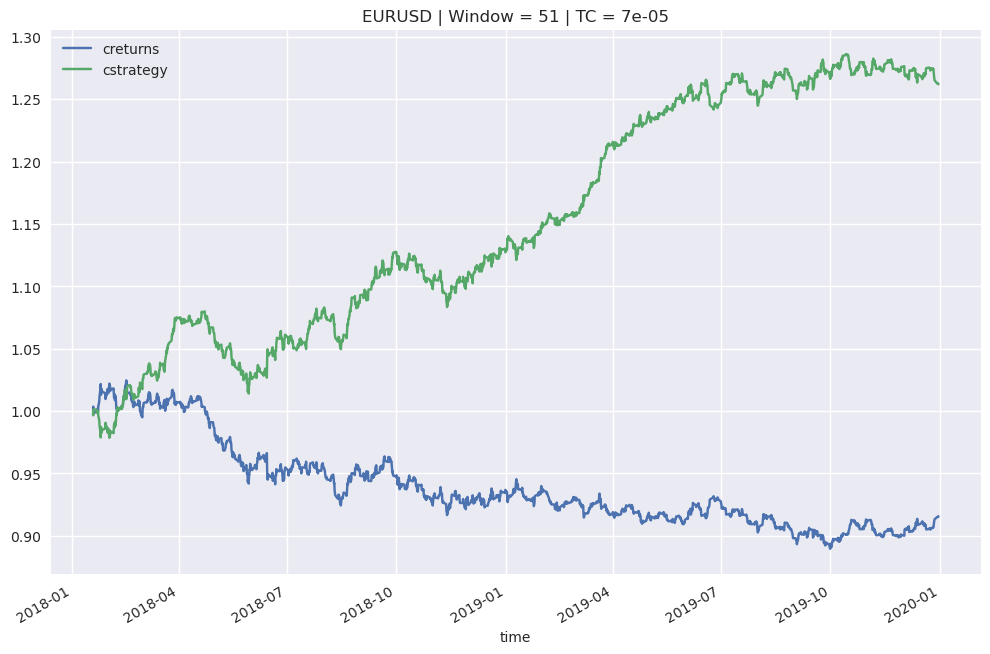

In [6]:
tester.plot_results()

__Required for many performance metrics: trading periods (6h) per year__ 

In [ ]:
tester.data

In [ ]:
tp_year = (tester.data.price.count() / ((tester.data.index[-1] - tester.data.index[0]).days / 365.25))
tp_year

In [ ]:
tester.results

__Multiple__

In [ ]:
def calculate_multiple(series):
    return np.exp(series.sum())

In [ ]:
calculate_multiple(tester.results.strategy)

__CAGR__

In [ ]:
def calculate_cagr(series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1

In [ ]:
calculate_cagr(tester.results.strategy)

__annualized mean return__

In [ ]:
def calculate_annualized_mean(series):
    return series.mean() * tp_year

In [ ]:
calculate_annualized_mean(tester.results.strategy)

__annualized std__

In [ ]:
def calculate_annualized_std(series):
    return series.std() * np.sqrt(tp_year)

In [ ]:
calculate_annualized_std(tester.results.strategy)

__Sharpe Ratio__

In [ ]:
def calculate_sharpe(series):
    if series.std() == 0:
        return np.nan
    else:
        return series.mean() / series.std() * np.sqrt(tp_year)

In [ ]:
calculate_sharpe(tester.results.strategy)

__+ Sortino Ratio, Max Drawdown, Max Drawdown Duration, Calmar Ratio, Kelly Criterion, and many more...__

## Updating the ConBacktester Class (advanced Performance Reporting)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [ ]:
# Version 2.1 (advanced Performance Reporting)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25)) # NEW
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        #multiple = round(self.results.cstrategy[-1], 6)
        #print("Strategy-Multiple: {}".format(multiple))
        
        self.print_performance() # NEW
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        '''
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(np.exp(self.results.strategy.sum()))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | Multiple: {}".format(window, round(perf, 6)))
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | Performance vs Windows", fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("Multiple", fontsize = 15)
            plt.show()   
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | WINDOW = {}".format(self.symbol, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [ ]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [ ]:
tester = ConBacktester(filepath= "intraday.csv", symbol = symbol, start = start, end = end, tc = tc)
tester

In [ ]:
tester.tp_year

In [ ]:
tester.test_strategy(51)

In [ ]:
tester.test_strategy(1)

In [ ]:
tester.calculate_sharpe(tester.results.strategy)

In [ ]:
tester.calculate_max_dd_duration(tester.results.strategy)

## Putting everything together: Advanced Performance Optimization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [ ]:
# Version 3.0 (advanced Performance Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        # NEW!!!
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | {}: {}".format(window, self.metric, round(perf, 6))) # updated
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | {} vs Windows".format(self.metric), fontsize = 15) # updated
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("{}".format(self.metric), fontsize = 15) # updated
            plt.show()   
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | WINDOW = {}".format(self.symbol, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [ ]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [ ]:
tester = ConBacktester(filepath= "intraday.csv", symbol = symbol, start = start, end = end, tc = tc)
tester

In [ ]:
tester.optimize_strategy((1, 1001, 1), metric= "Calmar")

In [ ]:
tester.plot_results()

In [ ]:
tester.visualize_many()

In [ ]:
tester.results_overview.sort_values(by = "Performance", ascending = False)